In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [ ]:
train_file = 'train_FD001.txt'
test_file = 'test_FD001.txt'
rul_file = 'RUL_FD001.txt'

In [18]:
train_df = pd.read_csv(train_file, sep=' ', header=None)
train_df.drop(train_df.columns[[26, 27]], axis=1, inplace=True)
train_df.columns = ['id', 'cycle', 'op1', 'op2', 'op3'] + [f'sensor{i}' for i in range(1, 22)]

Loading training data from train_FD001.txt


In [19]:
train_df.head()

,id,cycle,op1,op2,op3,sensor1,sensor2,sensor3,sensor4,sensor5,...,sensor12,sensor13,sensor14,sensor15,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


In [20]:
max_cycles_train = train_df.groupby('id')['cycle'].max().reset_index()
max_cycles_train.columns = ['id', 'max_cycle']

train_df = train_df.merge(max_cycles_train, on=['id'], how='left')
train_df['RUL'] = train_df['max_cycle'] - train_df['cycle']
train_df.drop('max_cycle', axis=1, inplace=True)

Calculating RUL for training data


In [21]:
train_df.head()

,id,cycle,op1,op2,op3,sensor1,sensor2,sensor3,sensor4,sensor5,...,sensor13,sensor14,sensor15,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21,RUL
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187


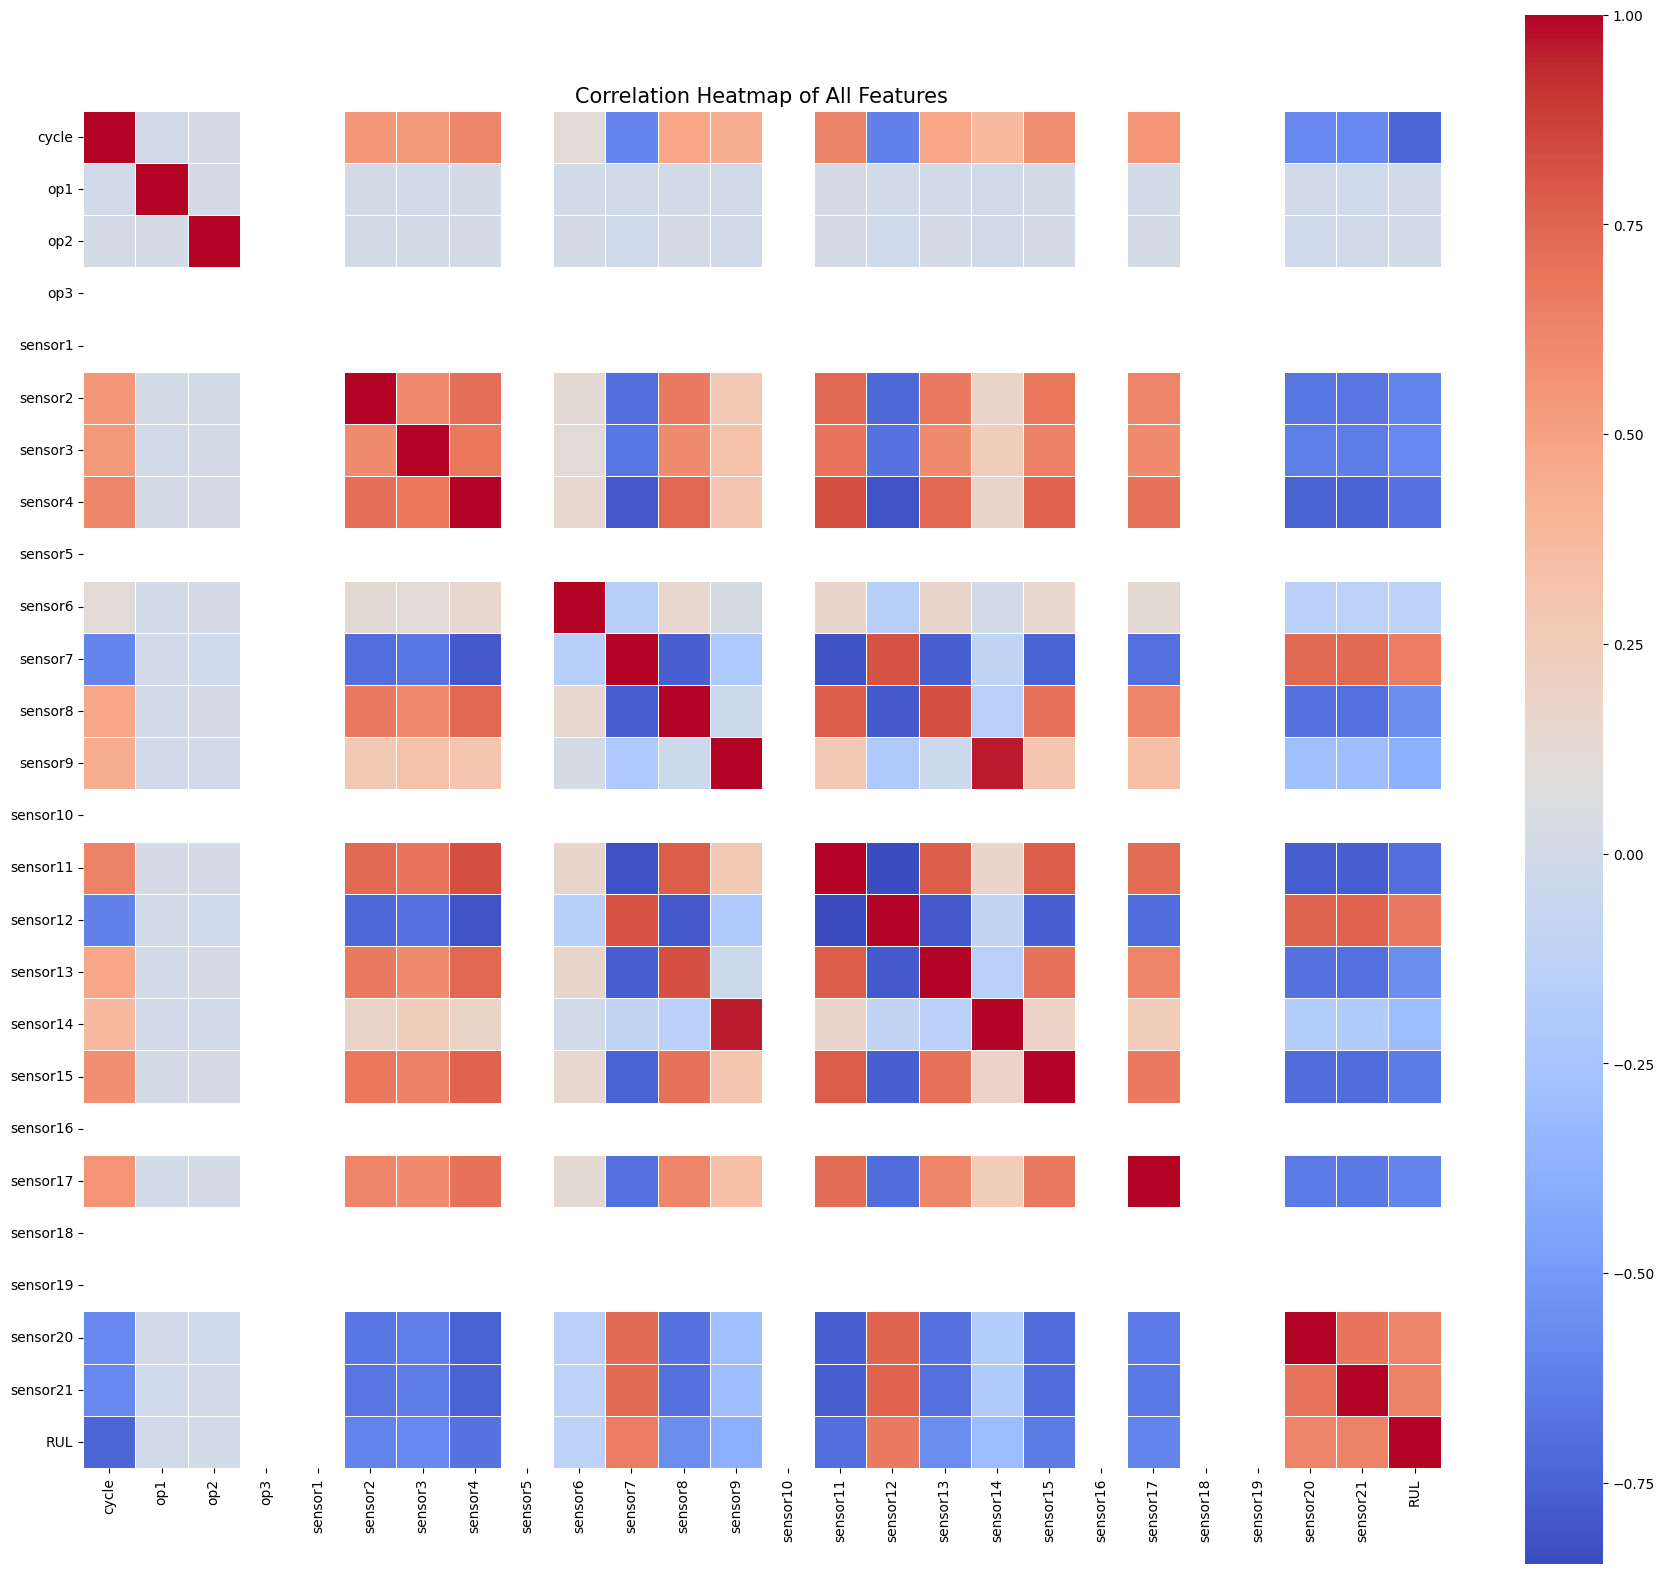

In [24]:
sensor_cols = [f'sensor{i}' for i in range(1, 22)]
op_cols = ['op1', 'op2', 'op3']
features_to_analyze = ['cycle'] + op_cols + sensor_cols + ['RUL']

# Create correlation matrix
corr_matrix = train_df[features_to_analyze].corr()

# Plot correlation heatmap
plt.figure(figsize=(18, 16))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=False, square=True, linewidths=.5)
plt.title('Correlation Heatmap of All Features', fontsize=15)
plt.tight_layout()
plt.show()

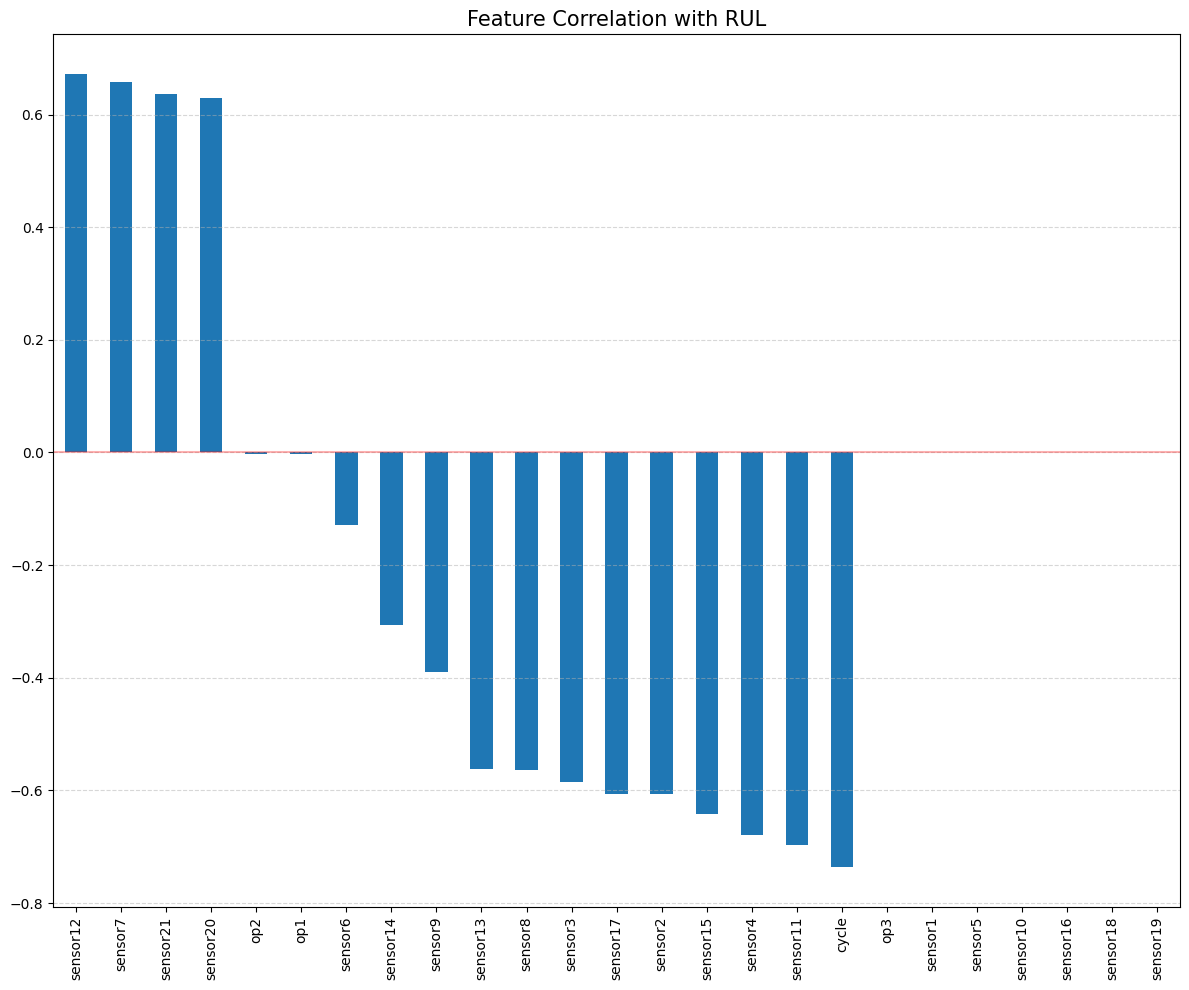

In [25]:
rul_correlation = corr_matrix['RUL'].sort_values(ascending=False)
plt.figure(figsize=(12, 10))
rul_correlation.drop('RUL').plot(kind='bar')
plt.title('Feature Correlation with RUL', fontsize=15)
plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [26]:
high_corr_sensors = rul_correlation[sensor_cols].abs().sort_values(ascending=False)
print("\nSensors ranked by absolute correlation with RUL:")
for sensor, corr in high_corr_sensors.items():
    print(f"{sensor}: {corr:.4f}")

# Select top correlated sensors
top_sensors = high_corr_sensors.index[:14].tolist()
print(f"\nSelected top {len(top_sensors)} correlated sensors: {top_sensors}")


Sensors ranked by absolute correlation with RUL:
sensor11: 0.6962
sensor4: 0.6789
sensor12: 0.6720
sensor7: 0.6572
sensor15: 0.6427
sensor21: 0.6357
sensor20: 0.6294
sensor2: 0.6065
sensor17: 0.6062
sensor3: 0.5845
sensor8: 0.5640
sensor13: 0.5626
sensor9: 0.3901
sensor14: 0.3068
sensor6: 0.1283
sensor1: nan
sensor5: nan
sensor10: nan
sensor16: nan
sensor18: nan
sensor19: nan

Selected top 14 correlated sensors: ['sensor11', 'sensor4', 'sensor12', 'sensor7', 'sensor15', 'sensor21', 'sensor20', 'sensor2', 'sensor17', 'sensor3', 'sensor8', 'sensor13', 'sensor9', 'sensor14']


In [27]:
selected_sensors = top_sensors
features = ['cycle', 'op1', 'op2', 'op3'] + selected_sensors

print(f"Selected features: {features}")

Selected features: ['cycle', 'op1', 'op2', 'op3', 'sensor11', 'sensor4', 'sensor12', 'sensor7', 'sensor15', 'sensor21', 'sensor20', 'sensor2', 'sensor17', 'sensor3', 'sensor8', 'sensor13', 'sensor9', 'sensor14']


In [28]:
def create_sequences(df, engine_ids, seq_length=50):
    sequences = []
    targets = []

    for engine_id in engine_ids:
        engine_data = df[df['id'] == engine_id][features].values
        engine_rul = df[df['id'] == engine_id]['RUL'].values

        for i in range(len(engine_data) - seq_length + 1):
            sequences.append(engine_data[i:i+seq_length])
            targets.append(engine_rul[i+seq_length-1])

    return np.array(sequences), np.array(targets)

In [30]:
train_engine_ids = train_df['id'].unique()
print(f"Number of training engines: {len(train_engine_ids)}")
train_sequences, train_targets = create_sequences(train_df, train_engine_ids)
print(f"Training sequences shape: {train_sequences.shape}, targets shape: {train_targets.shape}")

Creating training sequences
Number of training engines: 100
Training sequences shape: (15731, 50, 18), targets shape: (15731,)


In [31]:
test_engine_ids = test_df['id'].unique()
print(f"Number of test engines: {len(test_engine_ids)}")
test_sequences, test_targets = create_sequences(test_df, test_engine_ids)
print(f"Test sequences shape: {test_sequences.shape}, targets shape: {test_targets.shape}")

Creating test sequences
Number of test engines: 100
Test sequences shape: (8255, 50, 18), targets shape: (8255,)


In [32]:
scaler = StandardScaler()
train_sequences_reshaped = train_sequences.reshape(-1, train_sequences.shape[2])
test_sequences_reshaped = test_sequences.reshape(-1, test_sequences.shape[2])

train_sequences_scaled = scaler.fit_transform(train_sequences_reshaped)
test_sequences_scaled = scaler.transform(test_sequences_reshaped)

train_sequences = train_sequences_scaled.reshape(train_sequences.shape)
test_sequences = test_sequences_scaled.reshape(test_sequences.shape)

Normalizing data


In [34]:
X_train, X_val, y_train, y_val = train_test_split(
    train_sequences, train_targets, test_size=0.2, random_state=42
)

In [33]:
def build_lstm_model(input_shape):
    model = Sequential()

    # LSTM layers
    model.add(LSTM(units=64, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))

    model.add(LSTM(units=32, return_sequences=False))
    model.add(Dropout(0.2))

    # Dense layers
    model.add(Dense(units=16, activation='relu'))
    model.add(Dense(units=1, activation='linear'))  # Output layer for RUL prediction

    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

    return model

In [35]:
input_shape = (train_sequences.shape[1], train_sequences.shape[2])
model = build_lstm_model(input_shape)
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                        │ (None, 50, 64)              │          21,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 50, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_9 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 34,209 (133.63 KB)

 Trainable params: 34,209 (133.63 KB)

 Non-trainable params: 0 (0.00 B)

In [36]:
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_val, y_val),
    verbose=1
)

Epoch 1/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 39s 85ms/step - loss: 8039.0786 - mae: 69.8874 - val_loss: 1888.5192 - val_mae: 27.1002
Epoch 2/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 21s 53ms/step - loss: 1488.9648 - mae: 24.0291 - val_loss: 730.1397 - val_mae: 16.2631
Epoch 3/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 41s 53ms/step - loss: 811.0338 - mae: 18.1635 - val_loss: 535.5354 - val_mae: 14.0483
Epoch 4/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 42s 56ms/step - loss: 628.7833 - mae: 16.0886 - val_loss: 468.7738 - val_mae: 13.5236
Epoch 5/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 41s 55ms/step - loss: 550.3819 - mae: 15.0175 - val_loss: 340.2357 - val_mae: 11.3195
Epoch 6/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 40s 53ms/step - loss: 458.1895 - mae: 13.6427 - val_loss: 287.7325 - val_mae: 10.4155
Epoch 7/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 41s 54ms/step - loss: 356.6054 - mae: 12.4033 - val_loss: 265.6725 - val_mae: 10.0866
Epoch 8/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 20s 50ms/step - loss: 312.1613 - mae: 11.6002 - val_loss: 213.3805 - val_ma

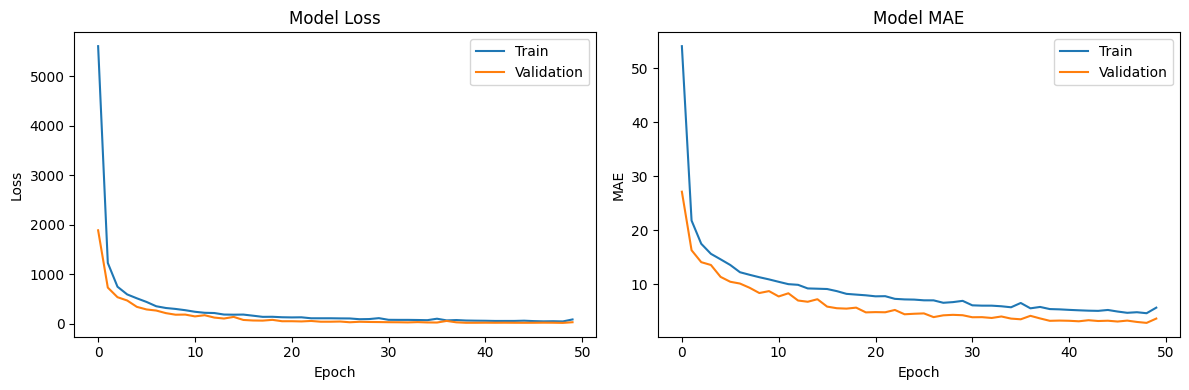

In [37]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Model MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

plt.tight_layout()
plt.show()

In [38]:
test_loss, test_mae = model.evaluate(test_sequences, test_targets, verbose=0)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test MAE: {test_mae:.4f}")

Test Loss: 1927.7489
Test MAE: 31.7039


Making predictions
492/492 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step
258/258 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step
Plotting results


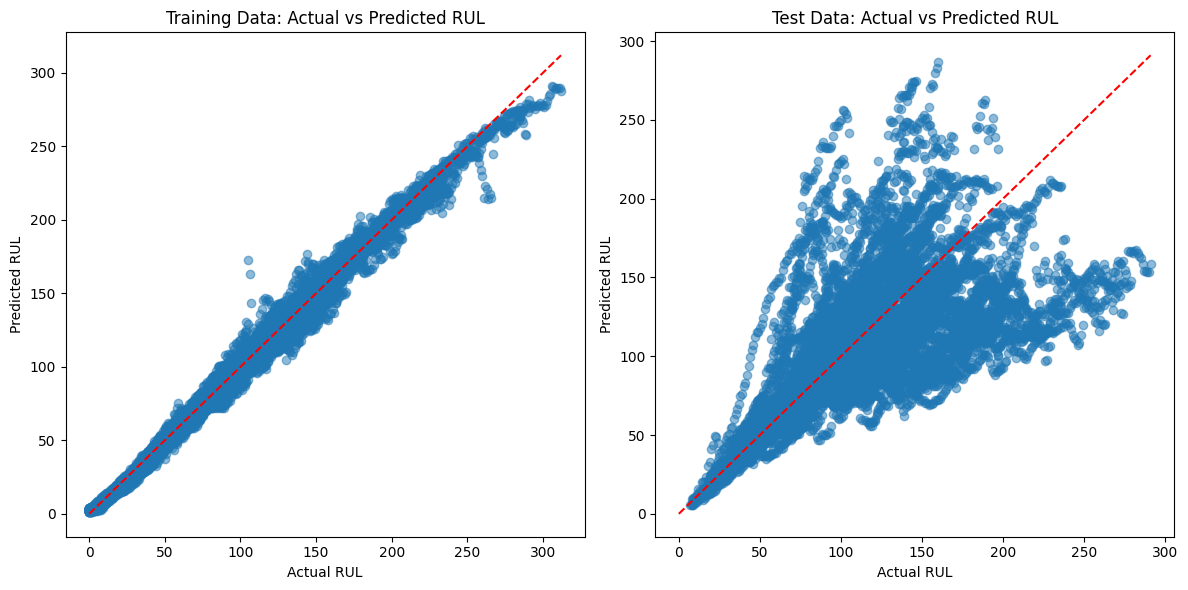

In [39]:
print("Making predictions")
train_predictions = model.predict(train_sequences).flatten()
test_predictions = model.predict(test_sequences).flatten()

# Plot results
print("Plotting results")
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(train_targets, train_predictions, alpha=0.5)
plt.plot([0, max(train_targets)], [0, max(train_targets)], 'r--')
plt.xlabel('Actual RUL')
plt.ylabel('Predicted RUL')
plt.title('Training Data: Actual vs Predicted RUL')

plt.subplot(1, 2, 2)
plt.scatter(test_targets, test_predictions, alpha=0.5)
plt.plot([0, max(test_targets)], [0, max(test_targets)], 'r--')
plt.xlabel('Actual RUL')
plt.ylabel('Predicted RUL')
plt.title('Test Data: Actual vs Predicted RUL')

plt.tight_layout()
plt.show()